In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
plt.style.use('seaborn')
%matplotlib inline

In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp
    
def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp
    
def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal
    
def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal
    
def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves
    
def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves
    
def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs
    
def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw
    
def get_ftir_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer2/timestamps'][:]
        return timestamps
    
def get_visible_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer1/timestamps'][:]
        return timestamps
    
def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs
    
def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertion_keys = list(h5_file[calibration_path].keys())
        insertions = [f'{calibration_path}/{key}' for key in insertion_keys]            
        return insertions
    
def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def construct_full_file_path(data_path, file_name):
    file_path = data_path + file_name
    return file_path

def create_list_of_sessions_in_file(file_name):
    sessions = []
    all_groups = create_list_of_items_in_node("group", file_name, "/")
    for group in all_groups:
        if (group[0:3] == 'ses') and (len(group) == 10):
            sessions.append(group)
    return sessions

def create_list_of_insertions_in_file(file_name):
    insertions = []
    sessions = create_list_of_sessions_in_file(file_name)
    for session in sessions:
        calibrations = create_list_of_calibrations_in_node(file_name, session)
        for calibration in calibrations:
            cal_insertions = create_list_of_insertions_in_calibration(file_name, calibration)
            for insertion in cal_insertions:
                insertions.append(insertion)
    return insertions
            
def get_insertion_timestamp(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_time = h5_file[insertion_path].attrs['start_time']
        ins_timestamp = pd.Timestamp(ins_time, unit='us')
        return ins_timestamp
    
def get_calibration_timestamp(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_time = h5_file[calibration_path].attrs['calibration_start_time']
        cal_timestamp = pd.Timestamp(cal_time, unit='us')
        return cal_timestamp  
    
def find_position_in_wavelength_vector(wavelength_vector, integer):
    position = np.where(np.isclose(wavelength_vector, integer, 1e-3))[0][0]
    return position

def normalize(value, max_value, min_value):
    normalized_value = (value - min_value)/(max_value - min_value)
    return normalized_value

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal
    
def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal
        
def get_ftir_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer2/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp
    
def get_visible_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer1/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp
    
def compute_3D_distance(x1, y1, z1, x2, y2, z2):
    distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return distance

def calculate_wavenumbers_from_wavelengths(wavelength_vector):
    return 10000000/wavelength_vector

def put_spectrum_in_wavenum_order(spectrum):
    return np.flip(spectrum)

# Exploring the soil/white blank alternation dataset, Visible light spectrometer, 5/6/21

Data were taken alternately between groups of 60 white blank spectra, then 60 spectra of the moist soil sample.  For the first 20 alternations, the spectra were taken in the cool morning outdoors, in the shade of the house.  The last 30 alternations were taken in the sunshine of the driveway.  Weather was cool and partly cloudy for much of the time.

In [23]:
# get the data

path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

df = pd.read_csv('data/soil_white_alternations_210506.csv')

insertions_df = pd.DataFrame()
for index in df.index.values:
    file_name = df['file_name'][index]
    file = path_name + file_name
    cal_path = df['session'][index] + "/" + df['calibration'][index]
    insertion_path = cal_path + "/" + df['insertion'][index]
    raw_spectra = get_visible_insertion_raw_spectra(file, insertion_path)
    timestamps = get_visible_insertion_timestamps(file, insertion_path)
    waves = get_visible_wavelength_vector(file, cal_path)
    #getting the dark spectrum to use in later absorbance calculations
    dark_spectrum = get_visible_dark_calibration_curve(file, cal_path)
    columns = np.arange(0, waves.shape[0], 1)
    
    # this gets the timestamps in Timestamp format
    ts = []
    for i in range(timestamps.shape[0]):
        timestamp = pd.Timestamp(timestamps[i], unit='us')
        ts.append(timestamp)
        
    insertion_df = pd.DataFrame(data=raw_spectra, index=ts, columns=columns, dtype=float)
    insertion_df['df_index'] = index
    # append the dataset for the insertion with the other datasets
    insertions_df = pd.concat([insertions_df, insertion_df])
# combine the spectra with the metadata from the spreadsheet
final_df = insertions_df.join(df, on="df_index")

In [4]:
final_df.shape

(6000, 523)

In [5]:
waves.shape

(512,)

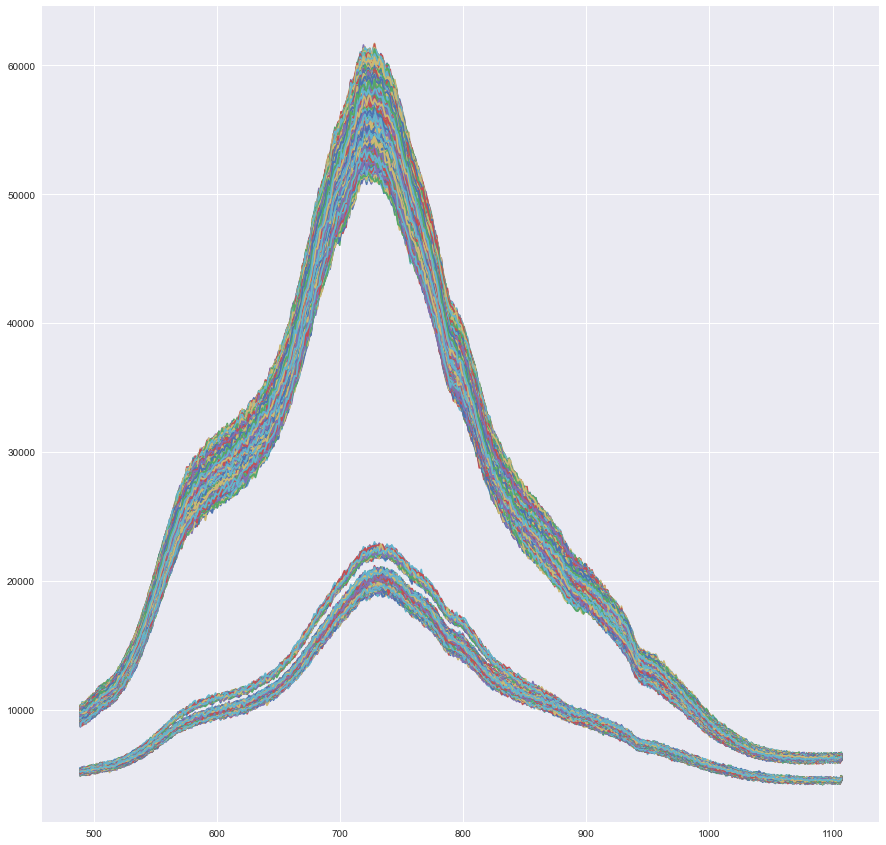

In [6]:
# plot all the raw data on one graph

fig, ax = plt.subplots(figsize=(15, 15))
for i in range(final_df.shape[0]):
    ax.plot(waves, final_df.iloc[i, 0:512])
plt.show()
plt.close()   

In [7]:
# put the timestamp in a column for use later
final_df['time'] = final_df.index
# for ease of use, split the dataset into soil and white blank datasets
soil_df = final_df.loc[final_df['target'] == 'soil'].copy()
white_df = final_df.loc[final_df['target'] == 'white blank'].copy()

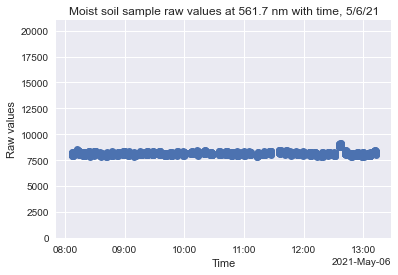

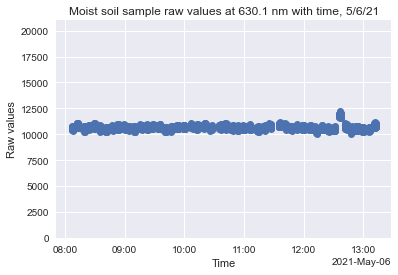

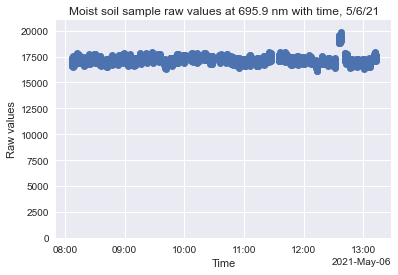

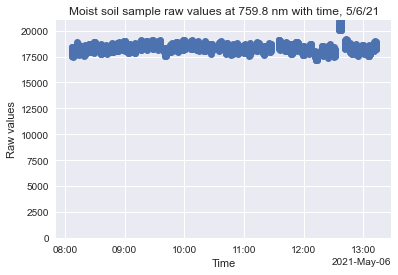

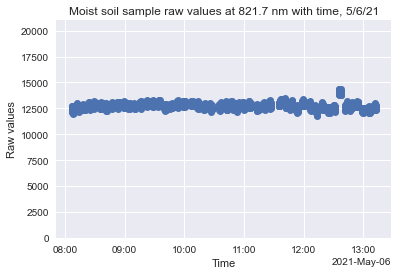

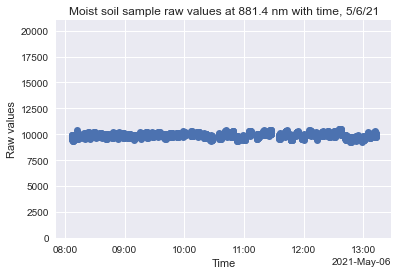

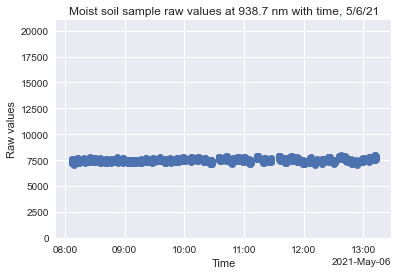

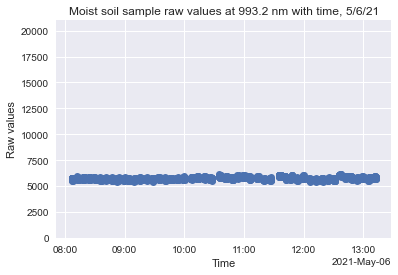

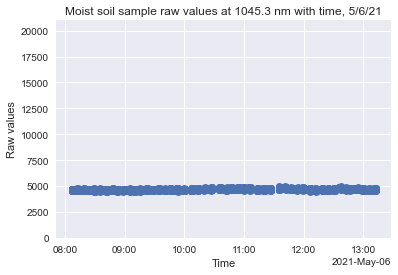

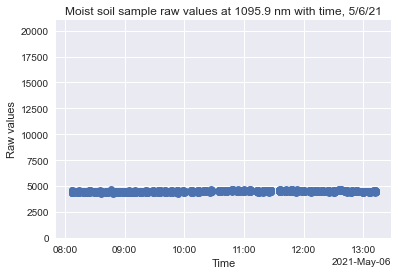

In [8]:
# explore how the raw spectra of the soil dataset varies with time at selected wavelengths
for i in range(50, 512, 50):
    fig, ax = plt.subplots()
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_title(f"Moist soil sample raw values at {waves[i]:0.1f} nm with time, 5/6/21")
    ax.set_ylabel("Raw values")
    ax.set_xlabel("Time")
    ax.set_ylim(0, 21000)

    ax.plot(soil_df[i], 'o')

    plt.show()
    plt.close()

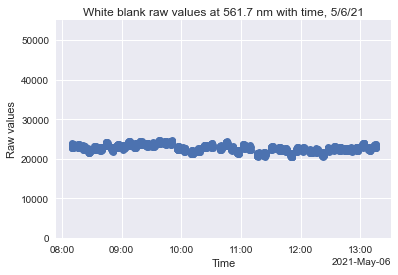

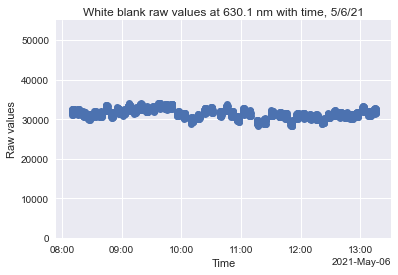

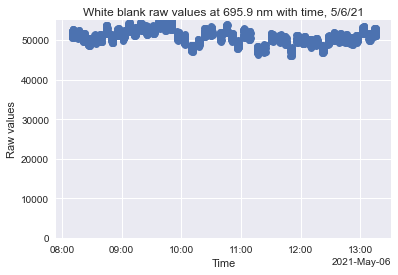

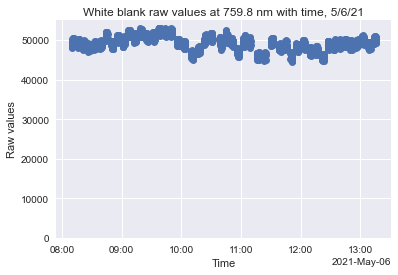

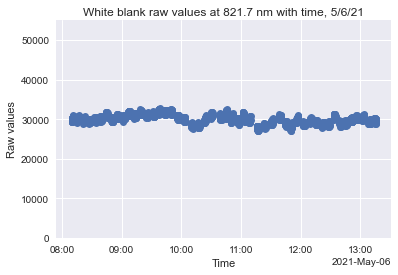

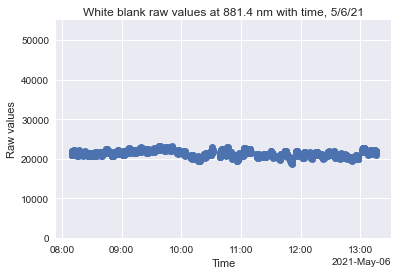

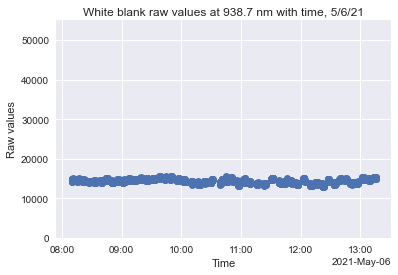

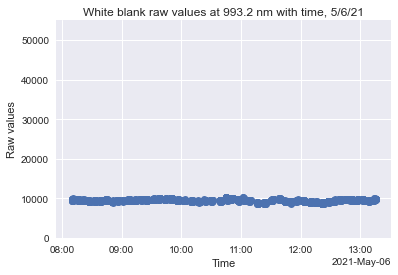

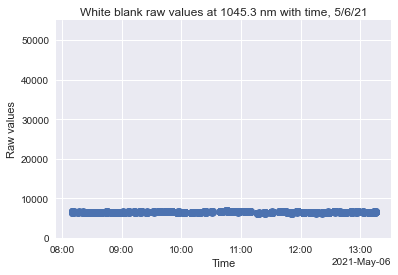

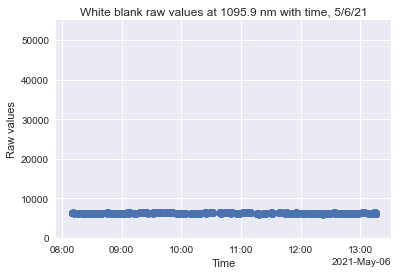

In [9]:
# explore how the raw spectra of the white blank dataset varies with time at selected wavelengths
for i in range(50, 512, 50):
    fig, ax = plt.subplots()
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_title(f"White blank raw values at {waves[i]:0.1f} nm with time, 5/6/21")
    ax.set_ylabel("Raw values")
    ax.set_xlabel("Time")
    ax.set_ylim(0, 55000)

    ax.plot(white_df[i], 'o')

    plt.show()
    plt.close()

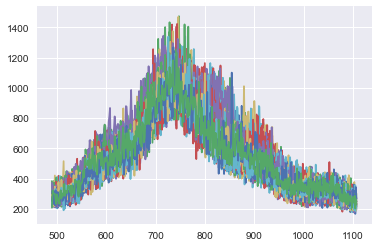

In [10]:
# This plot shows the range of the raw spectrum values at each wavelength for each soil insertion
soil_df.groupby('i_unique').agg(np.ptp)
insertion_range = soil_df.groupby('i_unique').agg(np.ptp)

for i in range(insertion_range.shape[0]):
    plt.plot(waves, insertion_range.iloc[i, 0:512])

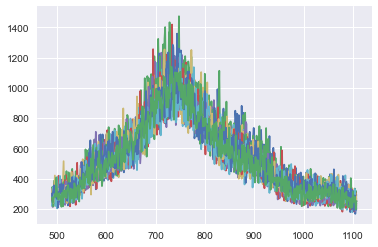

In [11]:
# This plot shows the range of the raw spectrum values at each wavelength for the first 20 soil insertions
soil_df.groupby('i_unique').agg(np.ptp)
insertion_range = soil_df.groupby('i_unique').agg(np.ptp)

for i in range(20):
    plt.plot(waves, insertion_range.iloc[i, 0:512])

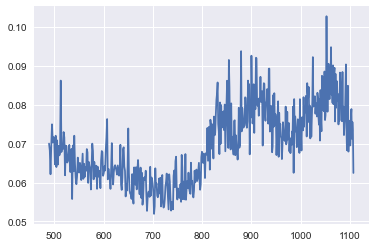

In [12]:
# This plot shows the maximum of the range as a ratio of the maximum value for the spectrum at each wavelength
range_max = insertion_range.iloc[:, 0:512].max(axis=0)
soil_max = soil_df.iloc[:, 0:512].max(axis=0)
range_ratio = range_max/soil_max
plt.plot(waves, range_ratio);

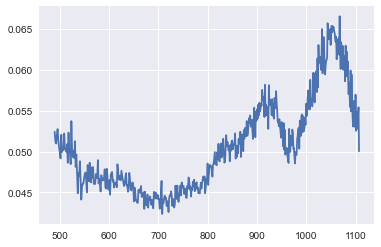

In [13]:
# Here is the mean of the range as a ratio of the maximum value of the spectrum at the wavelength
range_mean = insertion_range.iloc[:, 0:512].mean(axis=0)
mean_ratio = range_mean/soil_max
plt.plot(waves, mean_ratio)

In [14]:
soil_03 = final_df.loc[final_df['i_unique'] == 'c055i03'].copy()
white_cal_03 = final_df.loc[final_df['i_unique'] == 'c055i02'].iloc[-1, 0:512]

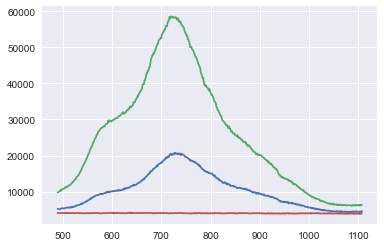

In [15]:
plt.plot(waves, soil_03.iloc[0, 0:512])
plt.plot(waves, white_cal_03.iloc[0:512])
plt.plot(waves, dark_spectrum)

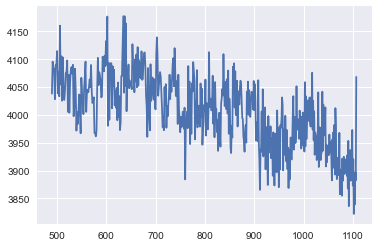

In [16]:
plt.plot(waves, dark_spectrum)

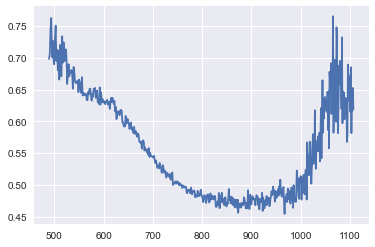

In [17]:
absorbance = calculate_absorbance_from_raw(soil_03.iloc[0, 0:512], white_cal_03, dark_spectrum)
plt.plot(waves, absorbance)

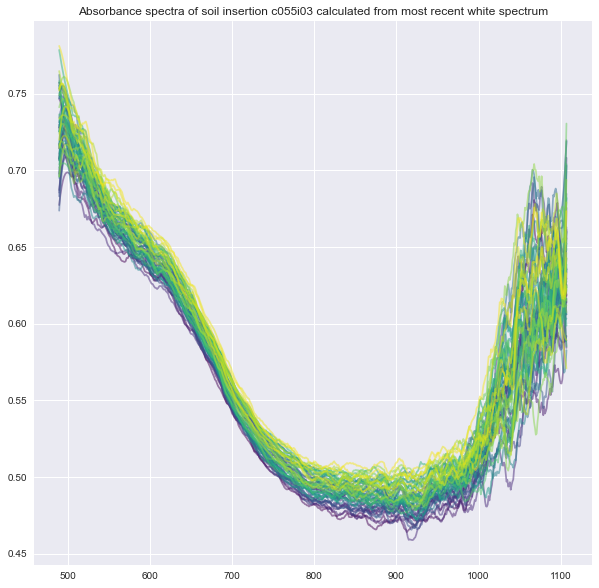

In [24]:
# in all asbsorbance calculations I use the same original dark reference spectrum
# The absorbance spectra for the second soil insertion calculated
# using the last spectrum of the previous white insertion as the 
# calibration white reference
soil_03 = final_df.loc[final_df['i_unique'] == 'c055i03'].copy()
white_cal_03 = final_df.loc[final_df['i_unique'] == 'c055i02'].iloc[-1, 0:512]

fig, ax = plt.subplots(figsize=(10,10))
# ax.set_ylim(0.35, 0.75)
# ax.set_xlim(1100, 2400)
ax.set_title("Absorbance spectra of soil insertion c055i03 calculated from most recent white spectrum")
for i in range(soil_03.shape[0]):
    color = plt.cm.viridis(normalize(i, soil_03.shape[0], 0))
        
    absorbance = calculate_absorbance_from_raw(soil_03.iloc[i, 0:512], white_cal_03, dark_spectrum)
    ax.plot(waves, savgol_filter(absorbance, 21, 3), color=color, alpha=0.5)
plt.show()
plt.close()

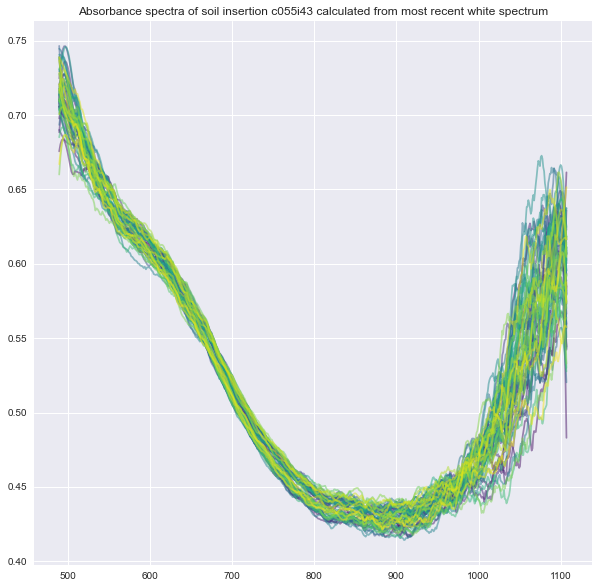

In [19]:
soil_43 = final_df.loc[final_df['i_unique'] == 'c055i43'].iloc[:, 0:512].copy()
white_43 = final_df.loc[final_df['i_unique'] == 'c055i42'].iloc[-1, 0:512].copy()
fig, ax = plt.subplots(figsize=(10,10))

# ax.set_ylim(0.35, 0.75)
# ax.set_xlim(1100, 2400)
ax.set_title("Absorbance spectra of soil insertion c055i43 calculated from most recent white spectrum")
for i in range(soil_43.shape[0]):
    color = plt.cm.viridis(normalize(i, soil_43.shape[0], 0))
    absorbance = calculate_absorbance_from_raw(soil_43.iloc[i, :], white_43, dark_spectrum)
    ax.plot(waves, savgol_filter(absorbance, 21, 3), color=color, alpha=0.5)
plt.show()
plt.close()

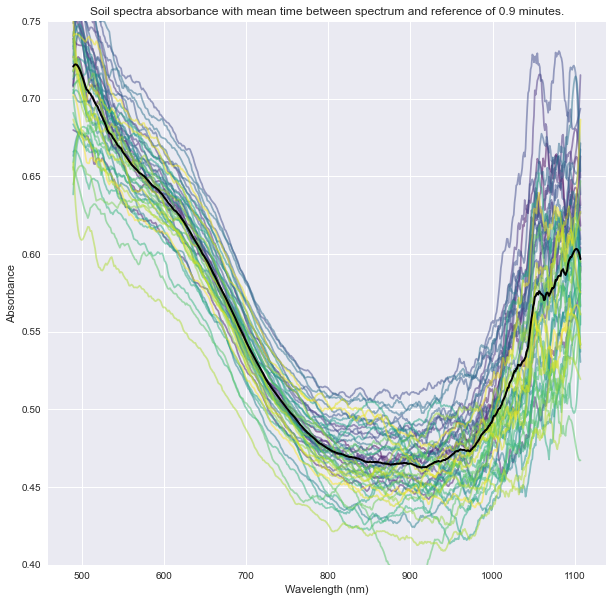

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_ylim(0.4, 0.75)

ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
time_deltas = []
absorbance_spectra = []

soil_white_diff = 1

for index in soil_df['df_index'].unique()[soil_white_diff:]:
    raw_spectrum = soil_df.loc[soil_df['df_index'] == index].iloc[0, 0:512]
    white_spectrum = white_df.loc[white_df['df_index'] == index - soil_white_diff].iloc[-1, 0:512]
    absorbance = calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum)
    white_time = white_df.loc[white_df['df_index'] == index - soil_white_diff].iloc[-1, :]['time']
    soil_time = soil_df.loc[soil_df['df_index'] == index].iloc[0, :]['time']
    time_delta = (soil_time - white_time)/np.timedelta64(1, 'm')
    time_deltas.append(time_delta)
    absorbance_spectra.append(absorbance)
    color = plt.cm.viridis(normalize(index, soil_df['df_index'].unique().max(), 0))
    ax.plot(waves, savgol_filter(absorbance, 21, 3), color=color, alpha=0.5)
    ax.set_title(f"Soil spectra absorbance with mean time between spectrum and reference of {np.mean(time_deltas):0.1f} minutes.")
mean_spectrum = np.mean(np.array(absorbance_spectra), axis=0)
ax.plot(waves, savgol_filter(mean_spectrum, 21, 3), 'k', lw=2)
plt.show()
plt.close()

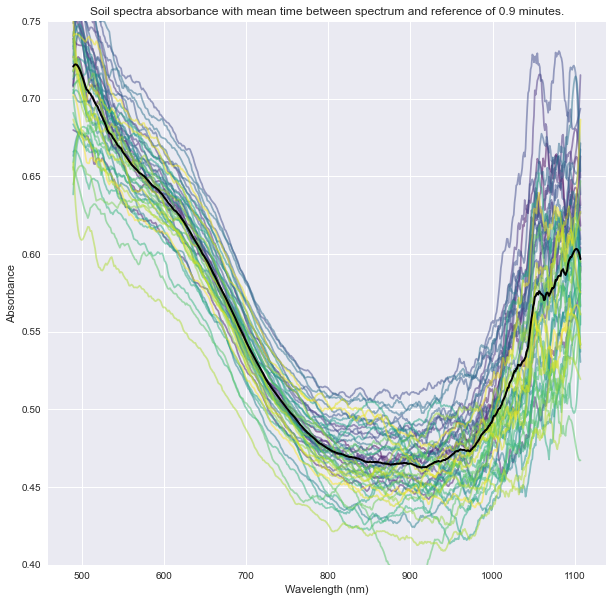

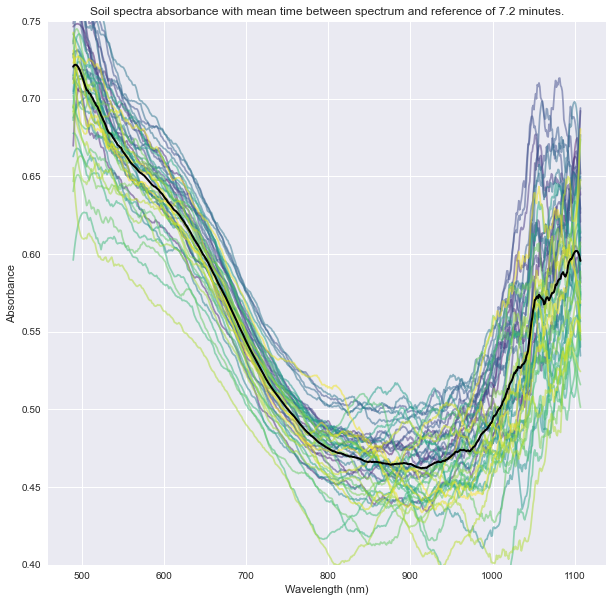

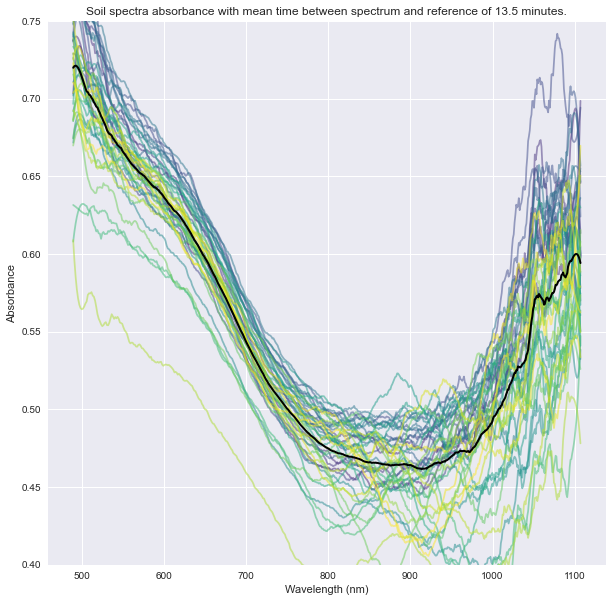

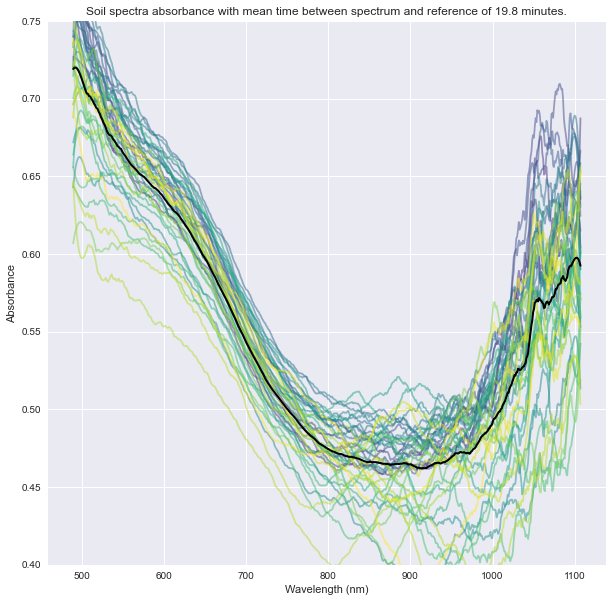

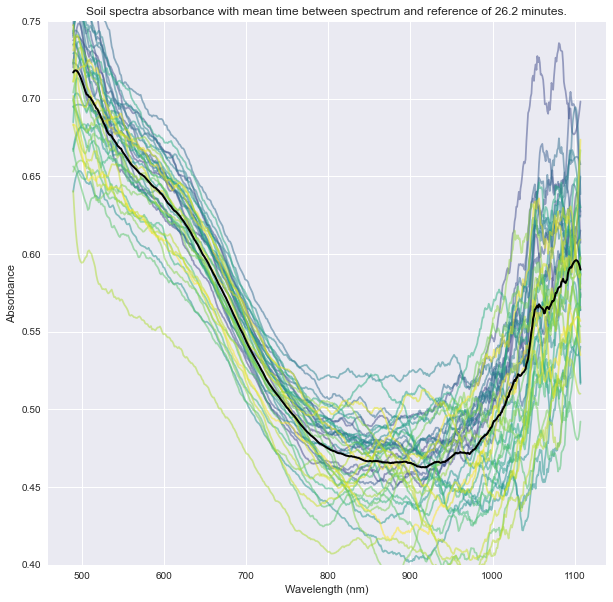

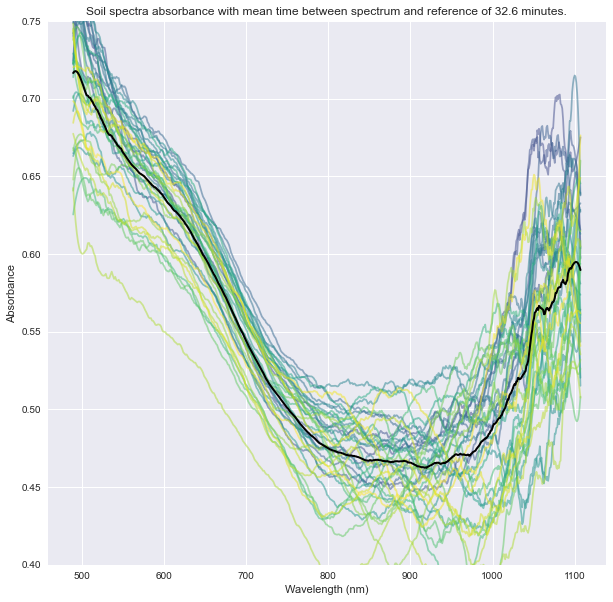

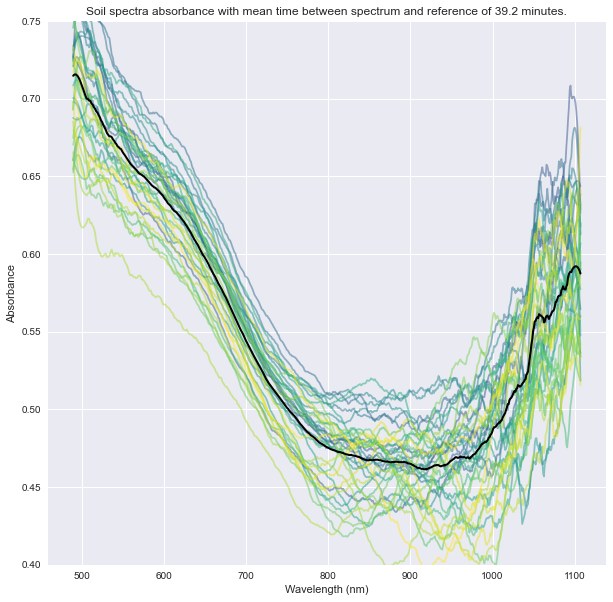

In [21]:
soil_white_diffs = [1, 3, 5, 7, 9, 11, 13]

for diff in soil_white_diffs:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_ylim(0.4, 0.75)
    
    ax.set_ylabel("Absorbance")
    ax.set_xlabel("Wavelength (nm)")
    time_deltas = []
    absorbance_spectra = []
    
    for index in soil_df['df_index'].unique()[diff:]:
        raw_spectrum = soil_df.loc[soil_df['df_index'] == index].iloc[0, 0:512]
        white_spectrum = white_df.loc[white_df['df_index'] == index - diff].iloc[-1, 0:512]
        absorbance = calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum)
        white_time = white_df.loc[white_df['df_index'] == index - diff].iloc[-1, :]['time']
        soil_time = soil_df.loc[soil_df['df_index'] == index].iloc[0, :]['time']
        time_delta = (soil_time - white_time)/np.timedelta64(1, 'm')
        time_deltas.append(time_delta)
        absorbance_spectra.append(absorbance)
        color = plt.cm.viridis(normalize(index, soil_df['df_index'].unique().max(), 0))
        ax.plot(waves, savgol_filter(absorbance, 21, 3), color=color, alpha=0.5)
                
        ax.set_title(f"Soil spectra absorbance with mean time between spectrum and reference of {np.mean(time_deltas):0.1f} minutes.")
                
    mean_spectrum = np.mean(np.array(absorbance_spectra), axis=0)
    ax.plot(waves, savgol_filter(mean_spectrum, 21, 3), 'k', lw=2)
    plt.show()
    plt.close()

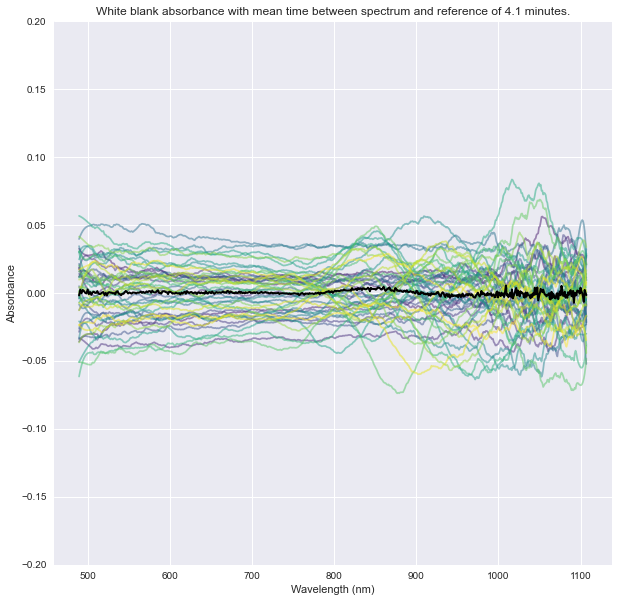

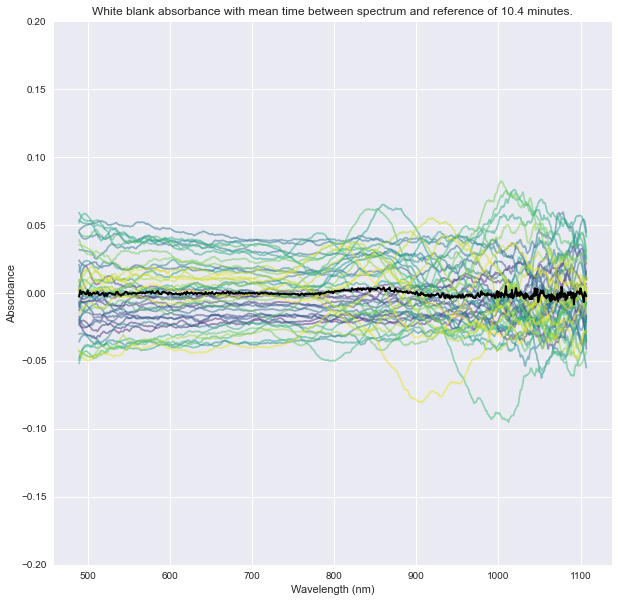

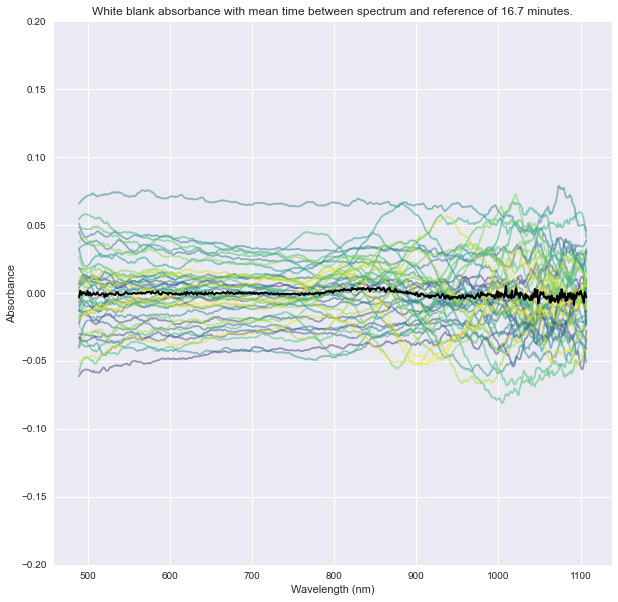

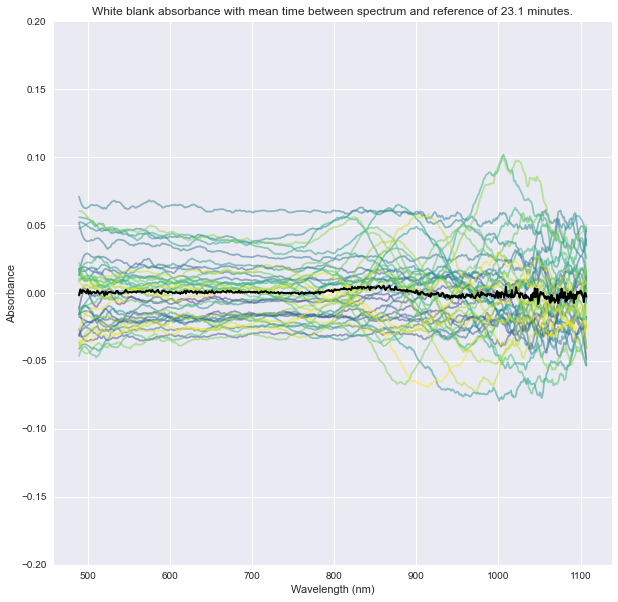

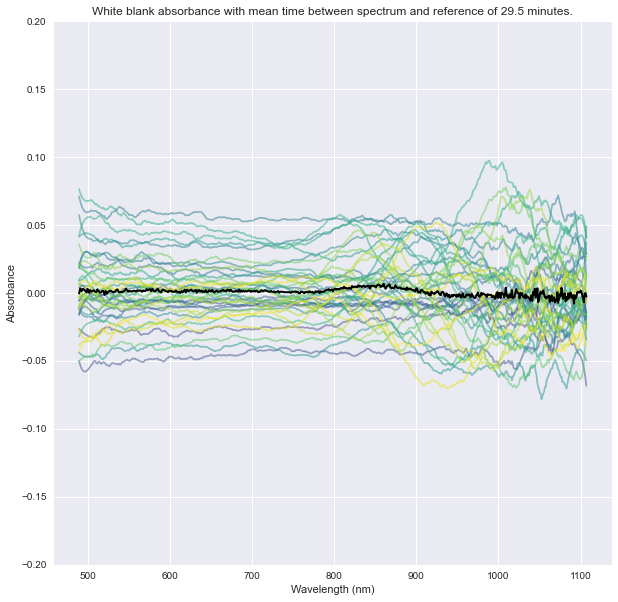

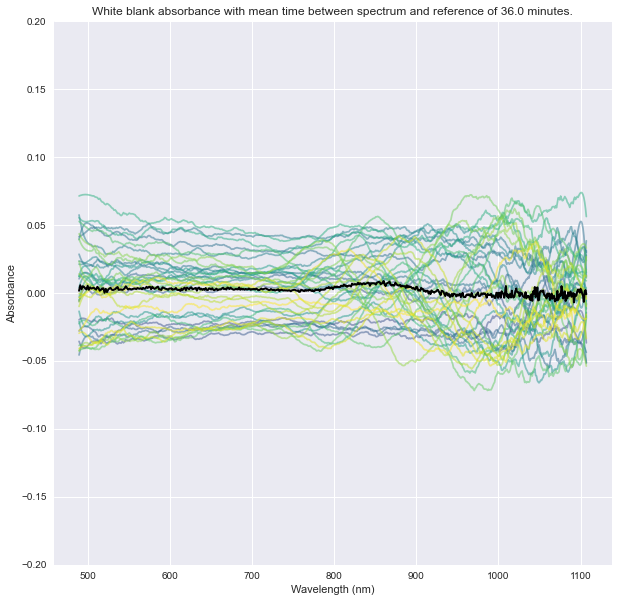

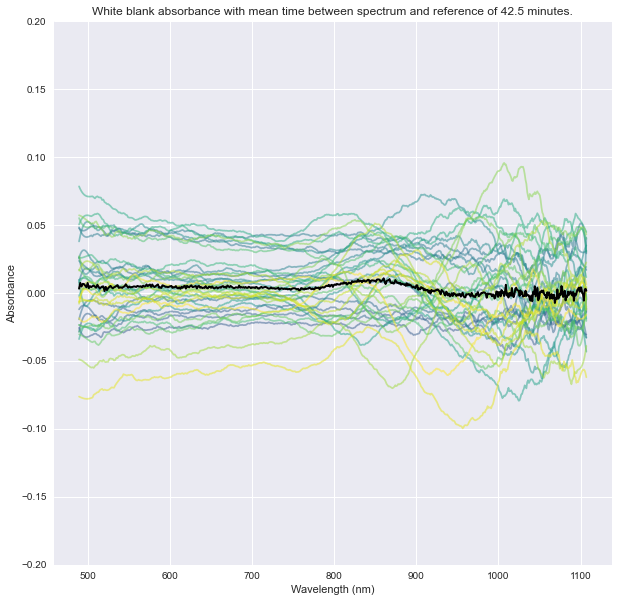

In [27]:
white_white_diffs = [2, 4, 6, 8, 10, 12, 14]

for diff in white_white_diffs:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_ylim(-0.2, 0.2)
    
    ax.set_ylabel("Absorbance")
    ax.set_xlabel("Wavelength (nm)")
    time_deltas = []
    absorbance_spectra = []
    
    for index in white_df['df_index'].unique()[diff:]:
        raw_spectrum = white_df.loc[white_df['df_index'] == index].iloc[0, 0:512]
        white_spectrum = white_df.loc[white_df['df_index'] == index - diff].iloc[-1, 0:512]
        absorbance = calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum)
        white_time = white_df.loc[white_df['df_index'] == index - diff].iloc[-1, :]['time']
        soil_time = white_df.loc[white_df['df_index'] == index].iloc[0, :]['time']
        time_delta = (soil_time - white_time)/np.timedelta64(1, 'm')
        time_deltas.append(time_delta)
        absorbance_spectra.append(absorbance)
        color = plt.cm.viridis(normalize(index, white_df['df_index'].unique().max(), 0))
        ax.plot(waves, savgol_filter(absorbance, 21, 3), color=color, alpha=0.5)
        ax.set_title(f"White blank absorbance with mean time between spectrum and reference of {np.mean(time_deltas):0.1f} minutes.")
    ax.plot(waves, np.mean(np.array(absorbance_spectra), axis=0), 'k', lw=2)
    plt.show()
    plt.close()